In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import numpy as np
import pickle
import pprint # Pretty Printer!
import warnings
import statistics

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
obs_path = ".../0. Data/Processed/All Processed Final Location"
covariates_path = ".../0. Data/Processed/covariates"
get_rid_of_these_sites_retn_too_large = ["H23-RS-167", "H-RS-1-98", "H23-RS-109"]
mean_var_figure_path = r"...\AbundanceConditionalOccupancy\Output\Mean and variance"

# Prepare truncated dataframes

In [3]:
# load predictive dataframe from the playback model
predicted_amps = pd.read_csv(r"...\0. Data\Processed\real data\predicted_distance_amplitudes_500_sm2.csv")
data_to_truncate = pd.read_csv(r"C:...\0. Data\Processed\All Processed Final Location\ready_to_truncate.csv")
SM2_status = pd.read_csv(os.path.join(covariates_path, "SM2 status.csv"))

## Add whether each recrdoing was taken with an SM2 or not

In [34]:
data_to_truncate.shape

(15675, 5)

In [36]:
data_to_truncate_sm2 = pd.merge(data_to_truncate, SM2_status, on='location')

In [39]:
data_to_truncate_sm2.shape
data_to_truncate_sm2.head()
data_to_truncate_sm2.SM2.value_counts()

0.0    9313
1.0    6354
Name: SM2, dtype: int64

| Target species  | Reference |
|------|-------|
| WTSP | VESP  |
| RCKI | AMRO  |
| TEWA | AMRO  |
| OSFL | WEME  |
| YRWA | CCSP  |
| REVI | BRBL  |


In [15]:
# WTSP: VESP, RCKI: AMRO, TEWA: AMRO, OSFL: WEME, YRWA: CCSP, REVI: BRBL
predicted_amps.head(2)

,Unnamed: 0,distance,species_code,BinForest,SM2,lwr,upr,predicted
0,1,15.000000,BRBL,FO,0,-13.796646,-11.737292,-12.766969
1,2,15.971944,BRBL,FO,0,-14.403690,-12.352155,-13.377922


In [16]:
# make a function that identifies the amplitude at which to truncate in forest and open for each bird.
spp_dict = {
    "WTSP": "VESP",
    "RCKI": "AMRO",
    "TEWA": "AMRO",
    "OSFL": "WEME",
    "YRWA": "CCSP",
    "REVI": "BRBL"
}


def map_spp(reference_spp):
    for key, value in spp_dict.items():
        if reference_spp == value:
            return key
    return None  # Return None or any default value you prefer if no match is found

# Now, apply this function to create a new column in your DataFrame
predicted_amps['spp'] = predicted_amps['species_code'].apply(map_spp)


In [17]:
predicted_amps

,Unnamed: 0,distance,species_code,BinForest,SM2,lwr,upr,predicted,spp
0,1,15.000000,BRBL,FO,0,-13.796646,-11.737292,-12.766969,REVI
1,2,15.971944,BRBL,FO,0,-14.403690,-12.352155,-13.377922,REVI
2,3,16.943888,BRBL,FO,0,-14.978565,-12.934736,-13.956651,REVI
3,4,17.915832,BRBL,FO,0,-15.524872,-13.488632,-14.506752,REVI
4,5,18.887776,BRBL,FO,0,-16.045635,-14.016868,-15.031251,REVI
...,...,...,...,...,...,...,...,...,...
9995,9996,496.112224,AMRO,OP,1,-69.702301,-59.269382,-64.485841,RCKI
9996,9997,497.084168,AMRO,OP,1,-69.769795,-59.313980,-64.541888,RCKI
9997,9998,498.056112,AMRO,OP,1,-69.837257,-59.358544,-64.597901,RCKI
9998,9999,499.028056,AMRO,OP,1,-69.904687,-59.403074,-64.653881,RCKI


In [18]:
predicted_amps.drop('Unnamed: 0', axis = 1, inplace=True)

In [19]:
predicted_amps[predicted_amps['spp'] == 'RCKI'][predicted_amps['distance'] == 15]

C:\Users\ilebe\AppData\Local\Temp\ipykernel_26244\2404362285.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predicted_amps[predicted_amps['spp'] == 'RCKI'][predicted_amps['distance'] == 15]


,distance,species_code,BinForest,SM2,lwr,upr,predicted,spp
2000,15.0,AMRO,FO,0,-10.735682,-8.708385,-9.722033,RCKI
4500,15.0,AMRO,FO,1,-15.206656,-13.076844,-14.141750,RCKI
7000,15.0,AMRO,OP,0,-11.528114,-9.168819,-10.348466,RCKI
9500,15.0,AMRO,OP,1,-15.940690,-13.595677,-14.768183,RCKI


make a dicionary of dictionaries where the key is the distance in interger and the value is the the dictionary of the open and forested amps at which to truncate at that distance 

## With SM2

In [22]:
# TEWA and RCI are the same, so use RCKI fro the TEWA part
species_of_interest = ['RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

# Filter DataFrames for 'BinForest' conditions with the addition of 'SM2' filtering
df_op_0 = predicted_amps[(predicted_amps['BinForest'] == 'OP') & (predicted_amps['SM2'] == 0)]
df_op_1 = predicted_amps[(predicted_amps['BinForest'] == 'OP') & (predicted_amps['SM2'] == 1)]
df_fo_0 = predicted_amps[(predicted_amps['BinForest'] == 'FO') & (predicted_amps['SM2'] == 0)]
df_fo_1 = predicted_amps[(predicted_amps['BinForest'] == 'FO') & (predicted_amps['SM2'] == 1)]

# Initialize the main dictionary
distance_dict = {}

for distance in range(30, 500):  # Assuming 500 is exclusive
    distance_dict[distance] = {}
    for species in species_of_interest:
        # Initialize nested dictionaries for this species
        distance_dict[distance][species] = {'OP': {'SM2_0': None, 'SM2_1': None},
                                            'FO': {'SM2_0': None, 'SM2_1': None}}

        op_rows_0 = df_op_0[df_op_0['spp'] == species]
        if not op_rows_0.empty:
            closest_op_row_0 = op_rows_0.iloc[(op_rows_0['distance'] - distance).abs().argsort()[:1]]
            closest_op_distance_0 = closest_op_row_0['distance'].values[0]
            if abs(closest_op_distance_0 - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species]['OP']['SM2_0'] = closest_op_row_0['predicted'].values[0]

        op_rows_1 = df_op_1[df_op_1['spp'] == species]
        if not op_rows_1.empty:
            closest_op_row_1 = op_rows_1.iloc[(op_rows_1['distance'] - distance).abs().argsort()[:1]]
            closest_op_distance_1 = closest_op_row_1['distance'].values[0]
            if abs(closest_op_distance_1 - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species]['OP']['SM2_1'] = closest_op_row_1['predicted'].values[0]

        fo_rows_0 = df_fo_0[df_fo_0['spp'] == species]
        if not fo_rows_0.empty:
            closest_fo_row_0 = fo_rows_0.iloc[(fo_rows_0['distance'] - distance).abs().argsort()[:1]]
            closest_fo_distance_0 = closest_fo_row_0['distance'].values[0]
            if abs(closest_fo_distance_0 - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species]['FO']['SM2_0'] = closest_fo_row_0['predicted'].values[0]

        fo_rows_1 = df_fo_1[df_fo_1['spp'] == species]
        if not fo_rows_1.empty:
            closest_fo_row_1 = fo_rows_1.iloc[(fo_rows_1['distance'] - distance).abs().argsort()[:1]]
            closest_fo_distance_1 = closest_fo_row_1['distance'].values[0]
            if abs(closest_fo_distance_1 - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species]['FO']['SM2_1'] = closest_fo_row_1['predicted'].values[0]

# Add TEWA logic remains unchanged, as the species 'TEWA' inherits the structure of 'RCKI'
for distance, species_dict in distance_dict.items():
    if 'RCKI' in species_dict:
        species_dict['TEWA'] = species_dict['RCKI']


In [23]:
distance_dict

{30: {'RCKI': {'OP': {'SM2_0': -16.8320506435711, 'SM2_1': -21.2517676912646},
   'FO': {'SM2_0': -16.6042664752603, 'SM2_1': -21.0239835229538}},
  'WTSP': {'OP': {'SM2_0': -19.648312256618, 'SM2_1': -24.0680293043114},
   'FO': {'SM2_0': -19.4205280883072, 'SM2_1': -23.8402451360006}},
  'YRWA': {'OP': {'SM2_0': -25.1729662320297, 'SM2_1': -29.5926832797232},
   'FO': {'SM2_0': -24.9451820637189, 'SM2_1': -29.3648991114124}},
  'REVI': {'OP': {'SM2_0': -19.876986686584, 'SM2_1': -24.2967037342775},
   'FO': {'SM2_0': -19.6492025182732, 'SM2_1': -24.0689195659667}},
  'OSFL': {'OP': {'SM2_0': -16.83484857037, 'SM2_1': -21.2545656180634},
   'FO': {'SM2_0': -16.6070644020592, 'SM2_1': -21.0267814497526}},
  'TEWA': {'OP': {'SM2_0': -16.8320506435711, 'SM2_1': -21.2517676912646},
   'FO': {'SM2_0': -16.6042664752603, 'SM2_1': -21.0239835229538}}},
 31: {'RCKI': {'OP': {'SM2_0': -17.1519182995954, 'SM2_1': -21.5716353472888},
   'FO': {'SM2_0': -16.9507107221445, 'SM2_1': -21.37042776983

In [26]:
# Initialize the list for formatted data
formatted_data = []

# Iterate through each distance and its corresponding bird data
for distance, birds in distance_dict.items():
    # Initialize the row dictionary with the current distance
    row = {"Distance": distance}
    # Iterate through each bird and its OP/FO values in the nested dictionary
    for bird, forest_types in birds.items():
        for habitat, sm2_values in forest_types.items():
            for sm2, value in sm2_values.items():
                # Create multi-level keys based on bird, habitat type, and SM2 value
                row[(bird, habitat, f"{sm2}")] = value
    # Append the row dictionary to the formatted_data list
    formatted_data.append(row)

# Create a DataFrame from the formatted data
df = pd.DataFrame(formatted_data)

# Set the 'Distance' column as the index of the DataFrame
df.set_index("Distance", inplace=True)

# Adjusting the column levels to reflect the new structure (Bird, Habitat Type, SM2)
df.columns = pd.MultiIndex.from_tuples(df.columns, names=["Bird", "Forest", "SM2"])


In [28]:
df.tail(5)

Bird           RCKI                                        WTSP             \
Forest           OP                    FO                    OP              
SM2           SM2_0      SM2_1      SM2_0      SM2_1      SM2_0      SM2_1   
Distance                                                                     
495      -60.010045 -64.429762 -72.512447 -76.932164 -62.826306 -67.246023   
496      -60.066124 -64.485841 -72.595104 -77.014821 -62.882386 -67.302103   
497      -60.122171 -64.541888 -72.677727 -77.097444 -62.938432 -67.358149   
498      -60.178184 -64.597901 -72.760316 -77.180033 -62.994445 -67.414162   
499      -60.234164 -64.653881 -72.842873 -77.262590 -63.050425 -67.470142   

Bird                                 YRWA             ...       REVI  \
Forest           FO                    OP             ...         FO   
SM2           SM2_0      SM2_1      SM2_0      SM2_1  ...      SM2_0   
Distance                                              ...              
495      -75.328709 -79.748426 -68.350960 -72.770677  ... -75.557383   
496      -75.411365 -79.831082 -68.407040 -72.826757  ... -75.640040   
497      -75.493988 -79.913705 -68.463086 -72.882803  ... -75.722663   
498      -75.576578 -79.996295 -68.519099 -72.938816  ... -75.805252   
499      -75.659134 -80.078851 -68.575079 -72.994796  ... -75.887809   

Bird                      OSFL                                        TEWA  \
Forest                      OP                    FO                    OP   
SM2           SM2_1      SM2_0      SM2_1      SM2_0      SM2_1      SM2_0   
Distance                                                                     
495      -79.977101 -60.012843 -64.432560 -72.515245 -76.934962 -60.010045   
496      -80.059757 -60.068922 -64.488639 -72.597902 -77.017619 -60.066124   
497      -80.142380 -60.124968 -64.544685 -72.680524 -77.100242 -60.122171   
498      -80.224969 -60.180982 -64.600699 -72.763114 -77.182831 -60.178184   
499      -80.307526 -60.236962 -64.656679 -72.845671 -77.265388 -60.234164   

Bird                                       
Forest                      FO             
SM2           SM2_1      SM2_0      SM2_1  
Distance                                   
495      -64.429762 -72.512447 -76.932164  
496      -64.485841 -72.595104 -77.014821  
497      -64.541888 -72.677727 -77.097444  
498      -64.597901 -72.760316 -77.180033  
499      -64.653881 -72.842873 -77.262590  

[5 rows x 24 columns]

## Without SM2

In [49]:
# TEWA and RCI are the same, so use RCKI fro the TEWA part
species_of_interest = ['RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

# Filter DataFrames for 'BinForest' conditions
df_op = predicted_amps[predicted_amps['BinForest'] == 'OP']
df_fo = predicted_amps[predicted_amps['BinForest'] == 'FO']

# Initialize the main dictionary
distance_dict = {}

for distance in range(30, 500):  # 300 inclusive
    distance_dict[distance] = {}
    for species in species_of_interest:
        # Initialize the list for this species with default None values
        distance_dict[distance][species] = [None, None]
        
        # Find the closest 'OP' row for this species and distance
        op_rows = df_op[df_op['spp'] == species]
        if not op_rows.empty:
            closest_op_row = op_rows.iloc[(op_rows['distance']-distance).abs().argsort()[:1]]
            closest_op_distance = closest_op_row['distance'].values[0]
            if abs(closest_op_distance - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species][0] = closest_op_row['predicted'].values[0]
        
        # Find the closest 'FO' row for this species and distance
        fo_rows = df_fo[df_fo['spp'] == species]
        if not fo_rows.empty:
            closest_fo_row = fo_rows.iloc[(fo_rows['distance']-distance).abs().argsort()[:1]]
            closest_fo_distance = closest_fo_row['distance'].values[0]
            if abs(closest_fo_distance - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species][1] = closest_fo_row['predicted'].values[0]

# Add TEWA
for distance, species_dict in distance_dict.items():
    # Check if 'RCKI' is a key in the current dictionary
    if 'RCKI' in species_dict:
        # Duplicate the 'RCKI' item under the new key 'TEWA'
        species_dict['TEWA'] = species_dict['RCKI']


In [50]:
# Transforming the data into a multi-level column DataFrame
# First, prepare the data
formatted_data = []
for distance, birds in distance_dict.items():
    row = {"Distance": distance}
    for bird, values in birds.items():
        row[(bird, "OP")] = values[0]
        row[(bird, "FO")] = values[1]
    formatted_data.append(row)

# Create a DataFrame
df = pd.DataFrame(formatted_data)
df.set_index("Distance", inplace=True)

# Adjusting the column levels
df.columns = pd.MultiIndex.from_tuples(df.columns, names=["Bird", "Forest"])

df

Bird           RCKI                  WTSP                  YRWA              
Forest           OP         FO         OP         FO         OP         FO   
Distance                                                                     
30       -19.083205 -17.994152 -21.799299 -20.710246 -27.139495 -26.050442  \
31       -19.395435 -18.339715 -22.111529 -21.055809 -27.451725 -26.396005   
32       -19.698870 -18.676482 -22.414964 -21.392576 -27.755160 -26.732772   
33       -20.281443 -19.325720 -22.997537 -22.041814 -28.337733 -27.382010   
34       -20.561514 -19.639123 -23.277608 -22.355217 -28.617804 -27.695413   
...             ...        ...        ...        ...        ...        ...   
495      -58.603008 -73.480164 -61.319102 -76.196258 -66.659298 -81.536454   
496      -58.651451 -73.561939 -61.367545 -76.278033 -66.707740 -81.618229   
497      -58.699860 -73.643681 -61.415954 -76.359775 -66.756150 -81.699971   
498      -58.748236 -73.725389 -61.464330 -76.441483 -66.804526 -81.781679   
499      -58.796579 -73.807064 -61.512673 -76.523158 -66.852868 -81.863354   

Bird           REVI                  OSFL                  TEWA             
Forest           OP         FO         OP         FO         OP         FO  
Distance                                                                    
30       -22.089641 -21.000588 -19.104777 -18.015724 -19.083205 -17.994152  
31       -22.401872 -21.346151 -19.417008 -18.361287 -19.395435 -18.339715  
32       -22.705307 -21.682919 -19.720443 -18.698055 -19.698870 -18.676482  
33       -23.287880 -22.332157 -20.303016 -19.347293 -20.281443 -19.325720  
34       -23.567950 -22.645559 -20.583086 -19.660695 -20.561514 -19.639123  
...             ...        ...        ...        ...        ...        ...  
495      -61.609445 -76.486601 -58.624581 -73.501737 -58.603008 -73.480164  
496      -61.657887 -76.568376 -58.673023 -73.583512 -58.651451 -73.561939  
497      -61.706296 -76.650117 -58.721432 -73.665253 -58.699860 -73.643681  
498      -61.754672 -76.731826 -58.769808 -73.746962 -58.748236 -73.725389  
499      -61.803015 -76.813501 -58.818151 -73.828637 -58.796579 -73.807064  

[470 rows x 12 columns]

In [29]:
df.to_csv(os.path.join(mean_var_figure_path, 'distance_predictive_df_500m_sm2.csv'))

In [9]:
# Make a dict like this one:

# bird: [open, forested]
dict_100m = {'REVI': [-33.47727, -34.41656],
            'OSFL': [-30.40729, -31.34658],
            'WTSP': [-33.02465, -33.96394],
            'YRWA': [-38.65988, -39.59917],
            'RCKI': [-30.48088, -31.42017],
            'TEWA': [-30.48088, -31.42017]}

# bird: [open, forested]
dict_150m = {'REVI': [-40.07877, -41.03906],
            'OSFL': [-37.00472, -37.96502],
            'WTSP': [-39.62246, -40.58276],
            'YRWA': [-45.27004, -46.23034],
            'RCKI': [-37.07850, -38.03879],
            'TEWA': [-37.07850, -38.03879]}

# bird: [open, forested]
dict_250m = {'REVI': [-50.61214, -51.57243],
            'OSFL': [-47.53809, -48.49839],
            'WTSP': [-50.15583, -51.11613],
            'YRWA': [-55.80341, -56.76371],
            'RCKI': [-47.61186, -48.57216],
            'TEWA': [-47.61186, -48.57216]}

In [40]:
data_to_truncate_sm2.head()

,location,recording_date_time,species_code,Year_since_logging,mean_amp,SM2
0,H22-CC-0,2022-06-16 05:07:00,TEWA,9,-23.525,0.0
1,H22-CC-0,2022-06-16 05:07:00,RCKI,9,-37.265,0.0
2,H22-CC-0,2022-06-16 05:37:00,TEWA,9,-26.680,0.0
3,H22-CC-0,2022-06-16 05:52:00,TEWA,9,-26.150,0.0
4,H22-CC-0,2022-06-16 05:52:00,WTSP,9,-39.015,0.0


### Without SM2

In [52]:

# No SM2
def filter_dataframes_by_distance(dataframe, distance_dicts):
    # Dictionary to store each distance's filtered dataframe
    filtered_dfs = {}
    
    for distance in range(30, 501):  # Iterate through distances 30-300
        filter_dict = distance_dicts.get(distance)
        if filter_dict is not None:  # Check if there's a filter dict for the current distance
            all_filtered_rows = []  # List to store filtered rows for this distance
            for species, values in filter_dict.items():

                condition_1 = (dataframe['species_code'] == species) & (dataframe['Year_since_logging'] < 11) & (dataframe['mean_amp'] >= values[0])  # OP
                condition_2 = (dataframe['species_code'] == species) & (dataframe['Year_since_logging'] >= 12) & (dataframe['mean_amp'] >= values[1])  # FO
                
                # Collect the filtered rows
                filtered_rows = dataframe[condition_1 | condition_2]
                all_filtered_rows.append(filtered_rows)
            
            # Concatenate all filtered rows for this distance into a single DataFrame
            filtered_df = pd.concat(all_filtered_rows, ignore_index=True)
            
            # Store the filtered dataframe in the dictionary with the distance as key
            filtered_dfs[distance] = filtered_df
    
    return filtered_dfs

filtered_dfs = filter_dataframes_by_distance(data_to_truncate_sm2, distance_dict)

# Accessing a specific filtered DataFrame, e.g., for 150 meters
# filtered_df_150m = filtered_dfs[150]

### With SM2

In [41]:
def filter_dataframes_by_distance(dataframe, distance_dicts):
    # Dictionary to store each distance's filtered dataframe
    filtered_dfs = {}
    
    for distance in range(30, 501):  # Iterate through distances 30-500
        filter_dict = distance_dicts.get(distance)
        if filter_dict is not None:  # Check if there's a filter dict for the current distance
            all_filtered_rows = []  # List to store filtered rows for this distance
            for species, habitats in filter_dict.items():
                for habitat_type, sm2_values in habitats.items():
                    for sm2, amp_threshold in sm2_values.items():
                        # Determine year range based on habitat type
                        year_condition = (dataframe['Year_since_logging'] < 11) if habitat_type == 'OP' else (dataframe['Year_since_logging'] >= 12)
                        # Convert SM2 to the correct type (assuming it's stored as float in the dataframe)
                        sm2_condition = (dataframe['SM2'] == float(sm2.split('_')[-1]))
                        # Apply amp threshold condition
                        amp_condition = (dataframe['mean_amp'] >= amp_threshold) if amp_threshold is not None else pd.Series([True] * len(dataframe))
                        # Combine conditions: species, year, SM2, and amp threshold
                        condition = (dataframe['species_code'] == species) & year_condition & sm2_condition & amp_condition
                        
                        # Collect the filtered rows
                        filtered_rows = dataframe[condition]
                        if not filtered_rows.empty:
                            all_filtered_rows.append(filtered_rows)
            
            # Concatenate all filtered rows for this distance into a single DataFrame, if there are any
            if all_filtered_rows:
                filtered_df = pd.concat(all_filtered_rows, ignore_index=True)
                # Store the filtered dataframe in the dictionary with the distance as key
                filtered_dfs[distance] = filtered_df
    
    return filtered_dfs


filtered_dfs = filter_dataframes_by_distance(data_to_truncate_sm2, distance_dict)


In [43]:
filtered_dfs[200]

,location,recording_date_time,species_code,Year_since_logging,mean_amp,SM2
0,H22-CC-0,2022-06-16 05:07:00,RCKI,9,-37.265,0.0
1,H22-CC-0,2022-06-17 05:51:00,RCKI,9,-38.130,0.0
2,H22-CC-123,2022-06-11 07:11:00,RCKI,9,-39.550,0.0
3,H22-CC-123,2022-06-12 05:40:00,RCKI,9,-37.165,0.0
4,H-CC-1-40,2022-06-22 05:40:00,RCKI,2,-39.205,0.0
...,...,...,...,...,...,...
9686,H23-RS-215,2023-06-22 06:48:00,TEWA,12,-11.105,1.0
9687,H23-RS-215,2023-06-22 08:03:00,TEWA,12,-10.975,1.0
9688,H23-RS-215,2023-06-23 05:49:00,TEWA,12,-35.050,1.0
9689,H23-RS-215,2023-06-26 06:50:00,TEWA,12,-17.000,1.0


In [44]:
filtered_dfs[150].to_csv(os.path.join(obs_path, 'Truncated_150m_count_per_site_filtered_sm2.csv'), index=False)

In [ ]:
def sanity_check(dataframe, filter_dict):
    # Iterate over each species and its threshold values in the filter dictionary
    for species, values in filter_dict.items():
        # Extract rows corresponding to the current species
        species_df = dataframe[dataframe['species_code'] == species]
        
        # Check for rows that do not meet the filter conditions
        invalid_rows_1 = species_df[(species_df['Year_since_logging'] < 11) & (species_df['left_freq_filter_tag_peak_level_dbfs'] < values[0])]
        invalid_rows_2 = species_df[(species_df['Year_since_logging'] >= 12) & (species_df['left_freq_filter_tag_peak_level_dbfs'] < values[1])]
        
        # If any invalid rows are found, return a failure message with details
        if not invalid_rows_1.empty or not invalid_rows_2.empty:
            return f"Sanity check failed for species {species}. Check the filter conditions and data."
    
    # If all checks pass
    return "Sanity check passed! The filtered dataframe meets the conditions."

# Run the sanity check on the filtered dataframe
sanity_check_result = sanity_check(filtered_df_truncated_150m, dict_150m)
sanity_check_result


In [45]:
transcribed_tasks_all = pd.read_csv(r"C:\Users\ilebe\Documents\!Masters!\Analysis\0. Data\Processed\All Processed Final Location\transcribed_tasks_all.csv")

## Single dataframe processing

In [81]:
species_of_interest = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']
number_of_visits_per_site = pd.read_csv(os.path.join(obs_path, "number_of_transcribed_recordings_per_site.csv"))
list_of_sites_to_use = number_of_visits_per_site[number_of_visits_per_site['number_of_visits'] >= 10]['location'].to_list()

list_of_sites_to_use.remove("H23-RS-167")
list_of_sites_to_use.remove("H-RS-1-98")
list_of_sites_to_use.remove("H23-RS-109")

# Group by 'location', 'recording_date_time', and 'species_code', and count the number of times each species appears
grouped_all_df = filtered_dfs[250].groupby(['location', 'recording_date_time', 'species_code']).size().reset_index(name='count')

# Pivot the dataframe to have one row per site per visit and columns for each species
pivot_all_df = grouped_all_df.pivot_table(index=['location', 'recording_date_time'], columns='species_code', values='count', fill_value=0).reset_index()

# Filter the columns to include only the species of interest and fill NaN values with 0
pivot_all_df = pivot_all_df[['location', 'recording_date_time'] + species_of_interest].fillna(0)

# Check which combinations from transcribed_tasks_all are not present in pivot_all_df
combinations_not_found = transcribed_tasks_all[~transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1).isin(pivot_all_df[['location', 'recording_date_time']].apply(tuple, axis=1))]

# Display the unique combinations that are not found
unique_combinations_not_found = combinations_not_found[['location', 'recording_date_time']].drop_duplicates()

# Keeo inlty the site+visits that are properlytranscribed
count_per_site_transcriber_not_filtered = pivot_all_df.copy(deep=True)

# Create a set of unique location+recording_date_time combinations from transcribed_tasks_all.csv
# unique_transcribed_combinations = set(transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1))

# Filter the count_per_site_transcriber_not_filtered dataframe based on the unique combinations
filtered_count_per_site = count_per_site_transcriber_not_filtered[count_per_site_transcriber_not_filtered[['location', 'recording_date_time']].apply(tuple, axis=1).isin(unique_transcribed_combinations)]

# Step 4: Identify and add missing site-visit combinations
transcribed_combinations = set(transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1))
existing_combinations = set(filtered_count_per_site[['location', 'recording_date_time']].apply(tuple, axis=1))
missing_combinations = transcribed_combinations - existing_combinations
missing_combinations_df = pd.DataFrame(list(missing_combinations), columns=['location', 'recording_date_time'])
for species in species_of_interest:
    missing_combinations_df[species] = 0
updated_pivot_df = pd.concat([filtered_count_per_site, missing_combinations_df], ignore_index=True)

# Step 5: Filter the updated pivot table
final_filtered_pivot_df = updated_pivot_df[updated_pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1).isin(transcribed_combinations)]

In [82]:
final_filtered_pivot_df.to_csv(os.path.join(obs_path, "Truncated_250m_count_per_site_filtered_SM2 FIXED.csv"), index = False)

In [60]:
filtered_count_per_site.shape

(4477, 8)

In [66]:
len(missing_combinations)

5667

In [71]:
final_filtered_pivot_df.loc[final_filtered_pivot_df["location"] == 'AM-429-NW'].shape

(15, 8)

In [77]:
final_filtered_pivot_df.shape

(6248, 8)

In [22]:
species_of_interest = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

## Multiple dataframes processing

In [73]:
# Something is up with this one. Not the same output as with the code block above that creates just 1 df.
def process_dataframe(df, species_of_interest, transcribed_tasks_all):
    # Group by 'location', 'recording_date_time', and 'species_code', and count the number of times each species appears
    grouped_df = df.groupby(['location', 'recording_date_time', 'species_code']).size().reset_index(name='count')

    # Pivot the dataframe to have one row per site per visit and columns for each species
    pivot_df = grouped_df.pivot_table(index=['location', 'recording_date_time'], columns='species_code', values='count', fill_value=0).reset_index()
    # print(pivot_df.columns)

    species_present = list(pivot_df.columns)[2:]
    # print(species_present)
    # Filter the pivot_df columns to include only the species of interest and fill NaN values with 0
    pivot_df = pivot_df[['location', 'recording_date_time'] + species_present].fillna(0)

    # Check which combinations from transcribed_tasks_all are not present in pivot_df
    combinations_not_found = transcribed_tasks_all[~transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1).isin(pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1))]
    unique_combinations_not_found = combinations_not_found[['location', 'recording_date_time']].drop_duplicates()

    # Create a set of unique location+recording_date_time combinations from transcribed_tasks_all
    unique_transcribed_combinations = set(transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1))

    # Filter the pivot_df dataframe based on the unique combinations
    filtered_count_per_site = pivot_df[pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1).isin(unique_transcribed_combinations)]

    # Identify and add missing site-visit combinations
    transcribed_combinations = set(filtered_count_per_site[['location', 'recording_date_time']].apply(tuple, axis=1))
    existing_combinations = set(filtered_count_per_site[['location', 'recording_date_time']].apply(tuple, axis=1))
    missing_combinations = transcribed_combinations - existing_combinations
    missing_combinations_df = pd.DataFrame(list(missing_combinations), columns=['location', 'recording_date_time'])
    for species in species_of_interest:
        missing_combinations_df[species] = 0
    updated_pivot_df = pd.concat([filtered_count_per_site, missing_combinations_df], ignore_index=True)

    # Filter the updated pivot table
    final_filtered_pivot_df = updated_pivot_df[updated_pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1).isin(transcribed_combinations)]

    number_of_visits_per_site = pd.read_csv(os.path.join(obs_path, "number_of_transcribed_recordings_per_site.csv"))
    list_of_sites_to_use = number_of_visits_per_site[number_of_visits_per_site['number_of_visits'] >= 10]['location'].to_list()

    list_of_sites_to_use.remove("H23-RS-167")
    list_of_sites_to_use.remove("H-RS-1-98")
    list_of_sites_to_use.remove("H23-RS-109")
    
    final_filtered_pivot_df = final_filtered_pivot_df[final_filtered_pivot_df['location'].isin(list_of_sites_to_use)]


    return final_filtered_pivot_df

# Assuming filtered_dfs is your dictionary of DataFrames
processed_dfs = {}
for distance, df in filtered_dfs.items():
    # print(distance)
    processed_dfs[distance] = process_dataframe(df, species_of_interest, transcribed_tasks_all)

In [78]:
processed_dfs[150].shape # this should be 6248 rows, so something is up here

(2832, 8)

In [ ]:
# processed_dfs[150].to_csv(os.path.join(obs_path, "Truncated_150m_count_per_site_filtered_SM2 FIXED.csv"), index = False)

In [3]:
truncated_100m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_100m_count_per_site_filtered FIXED.csv"))
truncated_150m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_150m_count_per_site_filtered_SM2 FIXED.csv"))
truncated_250m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_250m_count_per_site_filtered_SM2 FIXED.csv"))
counts = pd.read_csv(os.path.join(obs_path, "count_per_site_filtered.csv")) # this is unlimited

In [76]:
truncated_150m_counts.shape

(6248, 8)

# A. Variance to mean ratio

In [25]:
def get_max_count(dataframe, bird):
    obs_count_10 = dataframe 
    sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
    sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

    filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]

    # Subsample to exactly 10 visits per site
    final_obs_count = filtered_obs_count.groupby('location').apply(lambda x: x.sample(n=10, replace=False, random_state = 123)).reset_index(drop=True)
    final_obs_count['visit_number'] = final_obs_count.groupby('location').cumcount() + 1
    N_matrix_visit_num = final_obs_count.pivot(index='location', columns='visit_number', values=f"{bird}").fillna(0).astype(int).values.tolist()

    # Calculate the maximum count encountered at each site
    max_counts = [max(site_counts) for site_counts in N_matrix_visit_num]
    return max_counts

# Dataframe argumant is from all the truncation distances
dataframe_type = 'dict of dataframes'
dataframe_type = "single dataframe"

bird = 'TEWA'

if dataframe_type == 'dict of dataframes':
    dist_dict = processed_dfs

    bird_mean_var_dict = {}
    for distance, dist_df in dist_dict.items():

        mean = statistics.mean(get_max_count(dist_df, bird))
        variance = statistics.variance(get_max_count(dist_df, bird))
        if mean != 0 and variance != 0:
            MV_ratio = mean/variance
            VM_ratio = variance/mean
            bird_mean_var_dict[distance] = [mean, variance, MV_ratio, VM_ratio]
else:
    dataframe = counts
    mean = statistics.mean(get_max_count(dataframe, bird))
    variance = statistics.variance(get_max_count(dataframe, bird))
    if mean != 0 and variance != 0:
        MV_ratio = mean/variance
        VM_ratio = variance/mean
VM_ratio
# WTSP_mean_var_df = pd.DataFrame.from_dict(bird_mean_var_dict, orient = 'index', columns = ['mean', 'variance', 'MV_ratio', 'VM_ratio'])

1.5983761524914535

In [68]:
WTSP_mean_var_df.to_csv(os.path.join(mean_var_figure_path, 'WTSP_mean_var_ratio_500.csv'))

## Read mean/variance csvs

In [85]:
bird_mean_var = pd.read_csv(os.path.join(mean_var_figure_path, 'YRWA_mean_var_ratio_500.csv'))

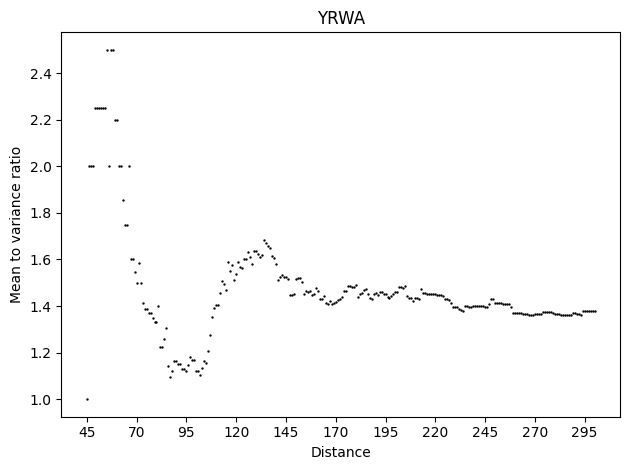

In [96]:
# Plotting mean to variance
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
plt.scatter(x = range(len(YRWA_mean_var_df.index)), 
            y = YRWA_mean_var_df['ratio'],
            s=0.5,
            c = 'black'
)

# Customizing the plot with fewer x-ticks and rotated labels
tick_spacing = 25  # Adjust this value as needed to reduce clutter
plt.xticks(range(0, len(YRWA_mean_var_df.index), tick_spacing), YRWA_mean_var_df.index[::tick_spacing], rotation=0)  # Rotate labels and use every 10th label

plt.title('YRWA')
plt.ylabel('Mean to variance ratio')
plt.xlabel('Distance')
plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
plt.savefig(os.path.join(mean_var_figure_path, 'YRWA_M2V plot.png'))


456


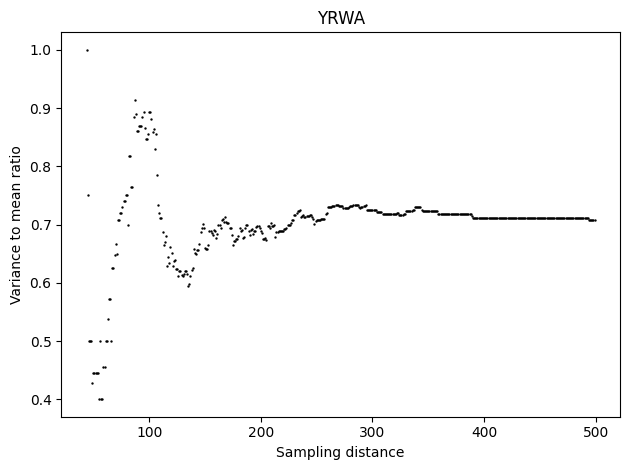

In [86]:
# Plotting variance to mean
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
# bird_mean_var = RCKI_mv
print(len(bird_mean_var.index))
plt.scatter(x = bird_mean_var['distance'], 
            y = bird_mean_var['VM_ratio'],
            s=0.5,
            c = 'black'
)

# Customizing the plot with fewer x-ticks and rotated labels
tick_spacing = 25  # Adjust this value as needed to reduce clutter
# plt.xticks(range(0, len(bird_mean_var.index), tick_spacing), bird_mean_var.index[::tick_spacing], rotation=0) 

plt.title('YRWA')
plt.xlabel('Sampling distance')
plt.ylabel('Variance to mean ratio')
plt.tight_layout() 
plt.savefig(os.path.join(mean_var_figure_path, 'YRWA_Var_2_Mean 500 plot.png'))


In [10]:
RCKI_mv['log_mean'] = np.log(RCKI_mv['mean'])

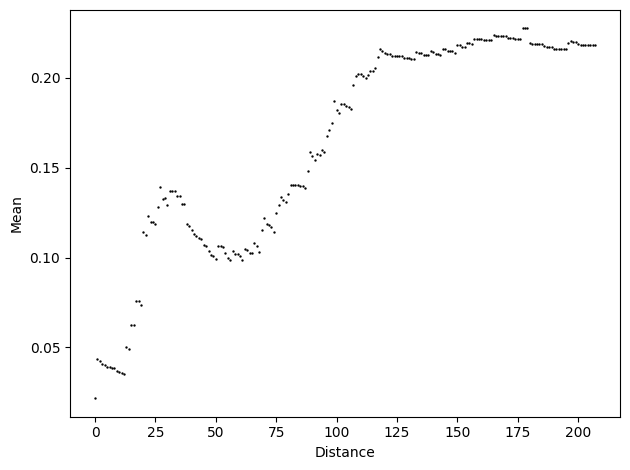

In [12]:
# Plotting
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
bird_mean_var = RCKI_mv
plt.scatter(x = range(len(bird_mean_var.index)), 
            y = bird_mean_var['mean'],
            s=0.5,
            c = 'black'
)

# Customizing the plot with fewer x-ticks and rotated labels
tick_spacing = 25  # Adjust this value as needed to reduce clutter
plt.xticks(range(0, len(bird_mean_var.index), tick_spacing), bird_mean_var.index[::tick_spacing], rotation=0)  # Rotate labels and use every 10th label

# plt.title('YRWA')
plt.ylabel('Mean')
plt.xlabel('Distance')
plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
# plt.savefig(os.path.join(mean_var_figure_path, 'YRWA_M2V plot.png'))


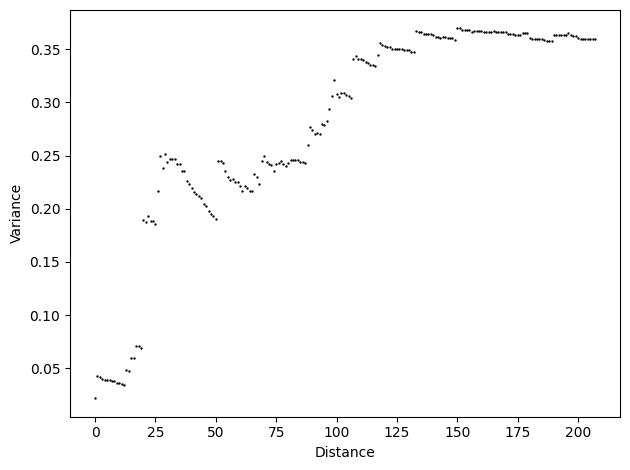

In [6]:
# Plotting
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
plt.scatter(x = range(len(bird_mean_var.index)), 
            y = bird_mean_var['variance'],
            s=0.5,
            c = 'black'
)

# Customizing the plot with fewer x-ticks and rotated labels
tick_spacing = 25  # Adjust this value as needed to reduce clutter
plt.xticks(range(0, len(bird_mean_var.index), tick_spacing), bird_mean_var.index[::tick_spacing], rotation=0)  # Rotate labels and use every 10th label

# plt.title('YRWA')
plt.ylabel('Variance')
plt.xlabel('Distance')
plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
# plt.savefig(os.path.join(mean_var_figure_path, 'YRWA_M2V plot.png'))


# B. Detection probailities

$$
P_{\text{detection}}(site) = \frac{N_{\text{visits with detections}}}{N_{\text{total visits}}}
$$

$$
P_{\text{average detection}} \ | \ vocalization = \frac{\sum_{i=1}^{n} P_{\text{detection}}(site_i)}{n}
$$

In [58]:
# Reading the obs_count_10.csv file\
obs_count_10 = truncated_250m_counts
# obs_count_10 = truncCounts250_10vis
# obs_count_10 = unlimitedCounts_10vis
# Filter out sites with less than 10 visits
sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]
# For each site, calculate the detection probability
site_list = list(filtered_obs_count['location'].unique())
# detection_probs = len(site_list)
# detection_probs = {}
detection_probs = []
bird = 'REVI'
for site in site_list:
    total_visits = filtered_obs_count.loc[filtered_obs_count['location'] == site].shape[0]
    # print(total_visits)
    detection_visits = filtered_obs_count.loc[filtered_obs_count['location'] == site].loc[filtered_obs_count[bird] >= 1].shape[0]
    if detection_visits != 0:
        visites_with_presence = detection_visits
        detection_probs.append(detection_visits/total_visits)
# print(detection_probs)


average_detection_prob = sum(detection_probs)/len(detection_probs)
print(average_detection_prob)
    

0.4522402158230007
